In [1]:
import numpy as np
from fenics import *

import math as m
from scipy.spatial import ConvexHull
import argparse 
import os
import time

In [4]:
SEED = 1
np.random.seed(SEED)

LLIM_X = 0.0
RLIM_X = 2000.0

LLIM_Y = 0.0
RLIM_Y = 2000.0

In [5]:
def create_hull():

    cx = (LLIM_X + RLIM_X) / 2.
    cy = (LLIM_X + RLIM_X) / 2.

    disp_x = np.random.uniform(160., 200.)
    disp_y = np.random.uniform(disp_x / 2., disp_x * 0.66)

    # center of the shape
    base = np.array(
        [[a, b] for a, b in zip(
            np.ones(100) * cx + np.random.uniform(-200., 200.),
            np.ones(100) * cy + np.random.uniform(-200., 200.))]
    )

    # a random angle to rotate the polygon
    angle = m.pi * np.random.normal(0, 90) / 180

    rotation_matrix = np.array([
        [m.cos(angle), -m.sin(angle)],
        [m.sin(angle), m.cos(angle)]
    ])


    data = np.random.normal(0, (disp_x, disp_y), (100, 2))
    data = data.dot(rotation_matrix) + base

    hull = ConvexHull(data)

    xx, yy = np.meshgrid(
        np.linspace(LLIM_X, RLIM_X, 128),
        np.linspace(LLIM_Y, RLIM_Y, 128)
    )

    res = []

    for x, y in zip(xx.flatten(), yy.flatten()):
        pts = np.concatenate((hull.points, np.array([[x, y]])))
        hull_tmp = ConvexHull(pts)
        if np.array_equal(hull.vertices,hull_tmp.vertices):
            res.append(1.)
        else:
            res.append(0.)

    return np.array(res).reshape(128, 128)

In [7]:
detector_coords = [(np.array([c, 2000.])) for c in np.linspace(0., 2000., 128)] 
buffer          = np.zeros((2, 128, 128))


def save(
    timestep, 
    curr_time,
    u_field, 
    v_field, 
    a_field
):
    
    data = [u_field(c) for c in detector_coords]
    buffer[:, timestep+1] = np.array(data).T

running:   0%|          | 0/1 [00:00<?, ?it/s]

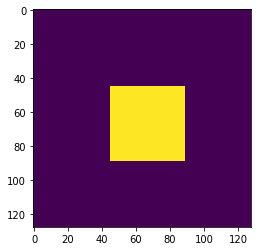

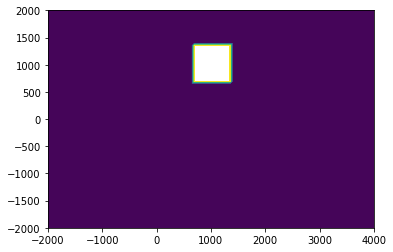

In [17]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dolfin_adjoint.elasticity_solver import elasticity_solver


n_samples   = int(1e4)
dataset_dir = os.path.join(os.getcwd(), 'dataset')
config_path = '/home/fenics/shared/datasets/heterogeneity/solver_config.yaml'

for i in tqdm(range(n_samples), desc='running'):
    
    hull = create_hull()
    np.save(os.path.join(dataset_dir, 'masks', f'{i}'), hull)
    
    slvr = elasticity_solver(
        hull.T,
        hull.T,
        hull.T,
        config_path
    )
 
    slvr.forward(save_callback=save)
    
    np.save(os.path.join(dataset_dir, 'seismograms', f'{i}'), buffer)